# Debayering (demosaicing) of a Bayer image

## Problem: 

Given a Bayer image, reconstruct the RGB image.

![](figures/Debayering.png)

Bayer pattern is a color filter array (CFA) used in digital cameras. It is a pattern of colored filters placed over the pixels of a digital image sensor. The pattern is used to separate the image into color components, and is used to reconstruct a full color image. The Bayer pattern is named after the German physicist Friedrich Bayer, who invented it in 1976.

![](figures/patterns.png)

## Metrics:

The metric used to evaluate the quality of the reconstruction is the Peak Signal-to-Noise Ratio (PSNR). The PSNR is defined as:

$$PSNR = 10 \log_{10} \left( \frac{MAX^2}{MSE} \right)$$

where $MAX$ is the maximum value of the image (255 for 8-bit images), and $MSE$ is the Mean Squared Error (MSE) between the original and the reconstructed image.

Another metric used to evaluate the quality of the reconstruction is the Structural Similarity Index (SSIM). The SSIM is defined as:

$$SSIM = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}$$

where $\mu_x$ and $\mu_y$ are the means of the original and the reconstructed image, respectively, $\sigma_x^2$ and $\sigma_y^2$ are the variances of the original and the reconstructed image, respectively, $\sigma_{xy}$ is the covariance between the original and the reconstructed image, and $C_1$ and $C_2$ are two constants that are used to stabilize the division by zero.

PSNR is responsible for the reconstruction of the intensity of the image, while SSIM is responsible for the reconstruction of the structure of the image.

Theese metrics are implemented in Tensorflow:
```python
tf.image.psnr(original, reconstructed, max_val)
tf.image.ssim(original, reconstructed, max_val)
```

/home/gosha20777/anaconda3/envs/debayer/lib/python3.9/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


26.1269
0.880857
0.244289


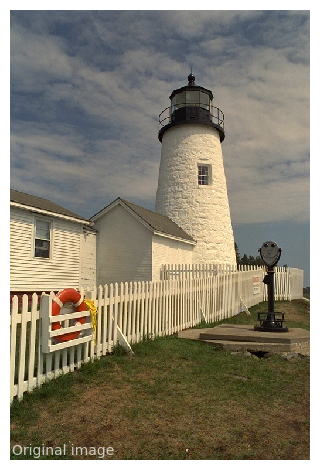

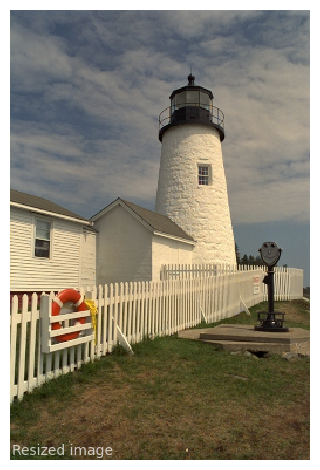

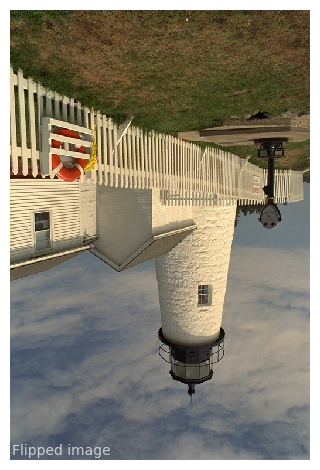

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [12]:
import tensorflow as tf
import colour
import cv2

# PSNR metric example

image = colour.io.read_image('data/Lighthouse.png')
resized_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
resized_image = cv2.resize(resized_image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_AREA)

psnr = tf.image.psnr(image, resized_image, max_val=1.0)
print(psnr.numpy())

# SSIM metric example
ssim = tf.image.ssim(image, resized_image, max_val=1.0)
print(ssim.numpy())

flip_image = cv2.flip(image, 0)

ssim = tf.image.ssim(image, flip_image, max_val=1.0)
print(ssim.numpy())

colour.plotting.plot_image(
    colour.cctf_encoding(image), 
    text_kwargs={'text': 'Original image'}
    )
colour.plotting.plot_image(
    colour.cctf_encoding(resized_image),
    text_kwargs={'text': 'Resized image'}
    )
colour.plotting.plot_image(
    colour.cctf_encoding(flip_image),
    text_kwargs={'text': 'Flipped image'}
    )

## Dataset:

The dataset used in this notebook is the [MSR Demosaicing Dataset](https://www.microsoft.com/en-us/download/confirmation.aspx?id=52535). 

The Microsoft Research Cambridge demosaicing data set consists of set of raw images, and their downscaled versions which can be used for learning and evaluating demosaicing (and possibly other tasks like denoising), both in linear-space and color-space.

The raw images are taken by two different cameras: 
- Panasonic Lumix DMC-LX3
- Canon EOS 550D


RGB images were obtained by superpixel interpolation of the raw images.
Raw images were obtained by downsampling the images by a factor of 2.

### Superpixel demosaicing

G = (G1 + G1) / 2
R = R
B = B

![](figures/superpixel.png)

### Downsampling

![](figures/downsampling.png)


- https://danielkhashabi.com/files/2013_2014_demosaicing/2014_RTF_demosaicing.pdf

In [13]:
import colour
import matplotlib.pyplot as plt
import debayering
from debayering import mosaicing

/home/gosha20777/anaconda3/envs/debayer/lib/python3.9/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


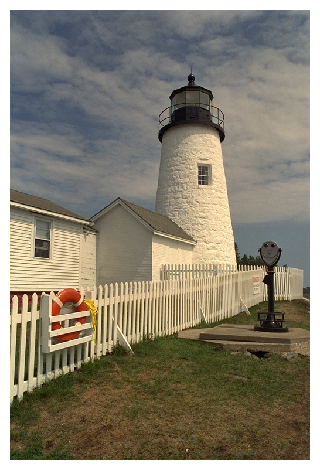

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [14]:
image = colour.io.read_image('data/Lighthouse.png')
colour.plotting.plot_image(colour.cctf_encoding(image))

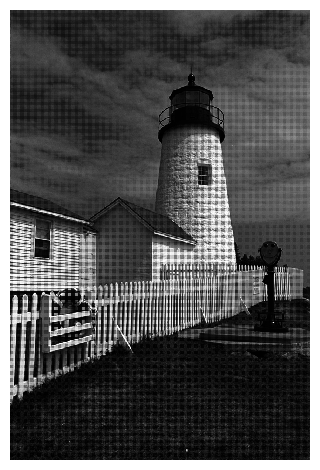

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [15]:
bayer = mosaicing.rgb2bayer(image, pattern="BGGR")
colour.plotting.plot_image(bayer)

## Bilinear Demosaicing

Bilinear demosaicing is a method used in digital image processing to reconstruct a full color image from a Bayer mosaic image sensor. The method uses a simple linear interpolation algorithm that takes the average of the color values of the neighboring pixels to estimate the missing color values. The result is a full color image with reduced color artifacts and improved resolution compared to the original Bayer mosaic image.

![](figures/bilinear.png)

This method is simple to implement and computationally efficient, but it can result in noticeable color artifacts and lack of detail in the resulting image compared to more advanced demosaicing methods.

![](figures/issues.png)


### Implementation

Convotion bilinear demosaicing:

![](figures/conv_imp.png)

- https://hal.science/hal-00683233/document
- https://www.researchgate.net/figure/Example-of-a-bilinear-interpolation-computed-with-convolution-filters-Left-the-original_fig1_37414255

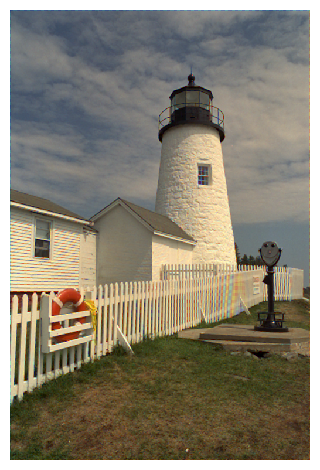

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [16]:
from debayering import bileniar
rgb = bileniar.bayer2rgb(bayer, pattern="BGGR")
colour.plotting.plot_image(colour.cctf_encoding(rgb))

### Malvar (2004) demosaicing algorithm

- http://www.ipol.im/pub/art/2011/g_mhcd/

It is a more advanced demosaicing algorithm compared to Bilinear Demosaicing, and it is known for producing high-quality images with reduced color artifacts and increased detail.

![](figures/malvar.png)

The Malvar Demosaicing Algorithm is based on the idea of estimating the missing color information for each pixel based on the gradient of the color information of its surrounding pixels. The algorithm uses a series of mathematical transformations and filters to compute the gradient of the color information and to produce a full-color image.

To improve upon the quality of the bilinear method, Malvar, He, and Cutler follow the work of Pei and Tam by adding Laplacian cross-channel corrections. The green component at a red pixel location is estimated as

![](figures/malvar1.png)
![](figures/malvar2.png)
![](figures/malvar3.png)


One of the key features of the Malvar Demosaicing Algorithm is that it takes into account the spatial frequency content of the image, meaning that it differentiates between high-frequency and low-frequency details in the image. This allows the algorithm to better preserve fine details and edges in the image while reducing color artifacts.

![](figures/malvar4.png)

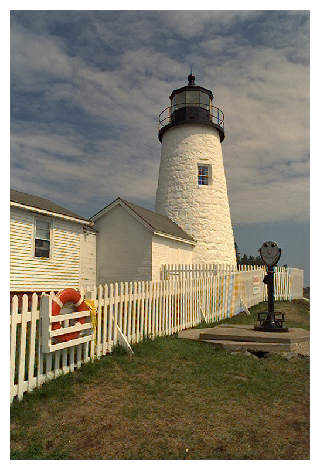

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [17]:
from debayering import malvar
rgb = malvar.bayer2rgb(bayer, pattern="BGGR")
colour.plotting.plot_image(colour.cctf_encoding(rgb))

### Menon (2007) demosaicing algorithm

- http://elynxsdk.free.fr/ext-docs/Demosaicing/todo/Menon_Andriani_IEEE_T_IP_2007.pdf

The Menon (2007) demosaicing algorithm is a state-of-the-art demosaicing method for converting a Bayer pattern image into a full-color image. This algorithm is based on a spatially adaptive color interpolation method that takes into account the spatial variability of color information in an image.

The Menon (2007) demosaicing algorithm starts by calculating the gradient of the chrominance information for each pixel in the Bayer pattern image. Based on this information, the algorithm identifies the pixels with high gradient values and assigns them a high weight in the interpolation process. This weighting process helps to preserve the sharpness and detail of the image while smoothing out any noise or artifacts.

The first step of the algorithm is to reconstruct the green
image along horizontal and vertical directions. To interpolate
the Bayer samples, we apply a five-coefficient FIR filter.

![](figures/menon1.png)

```python
G_H = np.where(G_m == 0, _cnv_h(CFA, h_0) + _cnv_h(CFA, h_1), G)
G_V = np.where(G_m == 0, _cnv_v(CFA, h_0) + _cnv_v(CFA, h_1), G)
```

![](figures/menon2.png)

Once the green component has been interpolated along both
horizontal and vertical directions and two green images have
been produced, a decision has to be made to select the filtering
direction that gives the best performance. In fact, the color
differences vary slowly and present abrupt changes only across
the edges. Therefore, an image typically has greater values of
the gradients of the color differences across the edges than along
them. 

![](figures/menon3.png)


Next, we calculate the gradients of the chrominances and, precisely, the horizontal gradient and the vertical one.

![](figures/menon4.png)
![](figures/menon5.png)

Next, the algorithm uses a directional filtering process to estimate the missing color information for each pixel based on its surrounding pixels. The filter coefficients are chosen based on the gradient information to ensure that the interpolation is optimized for the specific image.

![](figures/menon6.png)

Finally, the algorithm performs a spatial refinement step that adjusts the estimated color information based on the consistency of color information in the surrounding area. This step helps to reduce color artifacts and improve the overall quality of the resulting image.

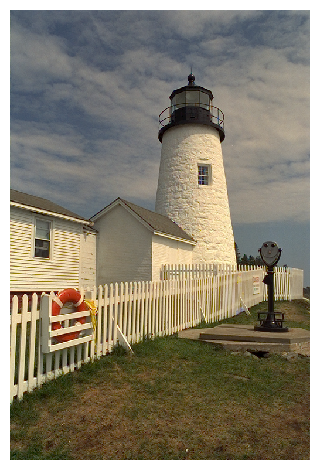

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [18]:
from debayering import menon

rgb = menon.bayer2rgb(bayer, pattern="BGGR")
colour.plotting.plot_image(colour.cctf_encoding(rgb))

/home/gosha20777/anaconda3/envs/debayer/lib/python3.9/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


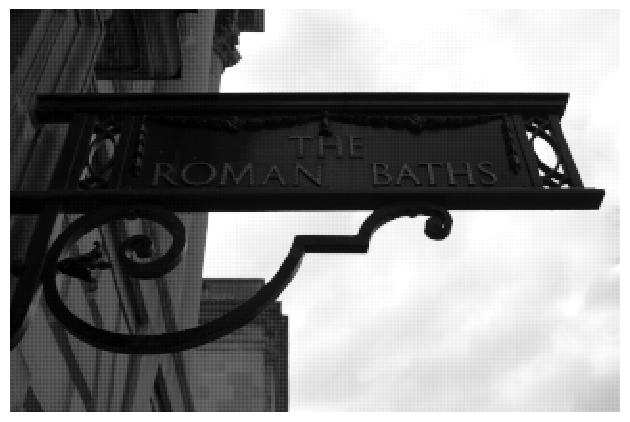

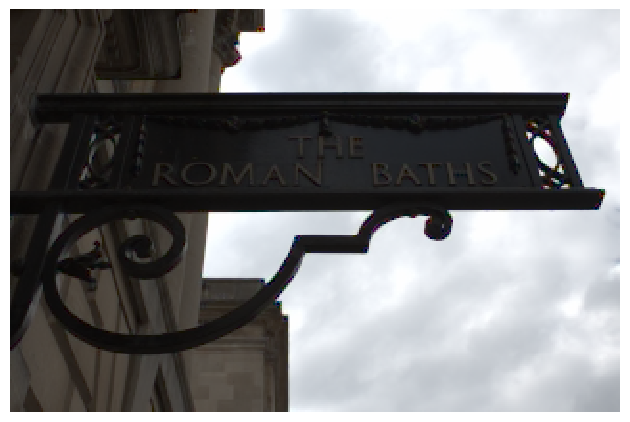

/home/gosha20777/anaconda3/envs/debayer/lib/python3.9/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


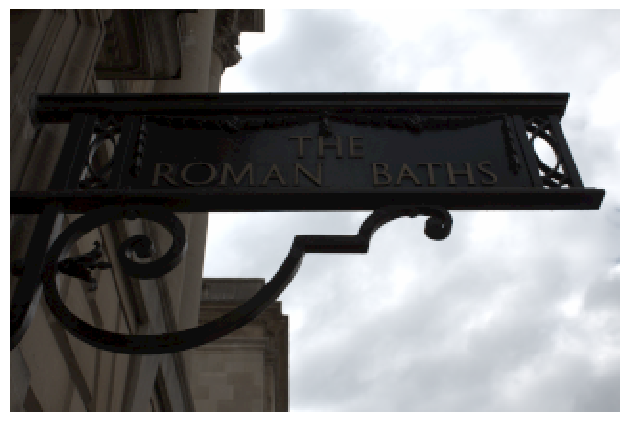

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [19]:
raw = colour.io.read_image('data/dataset/input/1.png')
colour.plotting.plot_image(colour.cctf_encoding(raw))
rgb = menon.bayer2rgb(raw, pattern="RGGB")
colour.plotting.plot_image(colour.cctf_encoding(rgb))
gt = colour.io.read_image('data/dataset/groundtruth/1.png')[:,:,:3]
colour.plotting.plot_image(colour.cctf_encoding(gt))

In [20]:
from debayering.utils import evaluate

psnr, ssim = evaluate(bileniar, "data/dataset")

print('Bileniar')
print("PSNR: ", psnr)
print("SSIM: ", ssim)

psnr, ssim = evaluate(malvar, "data/dataset")

print('Malvar')
print("PSNR: ", psnr)
print("SSIM: ", ssim)

psnr, ssim = evaluate(menon, "data/dataset")

print('Мenon')
print("PSNR: ", psnr)
print("SSIM: ", ssim)

/home/gosha20777/anaconda3/envs/debayer/lib/python3.9/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: "OpenImageIO" related API features are not available, switching to "Imageio"!
  warn(*args, **kwargs)


Bileniar
PSNR:  31.4404257724
SSIM:  0.931879263175
Malvar
PSNR:  32.391568235
SSIM:  0.939189145647
Мenon
PSNR:  33.1207515124
SSIM:  0.941916714245


## Deep Demosaicing

https://arxiv.org/pdf/1802.03769.pdf

![](figures/deep.png)

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import colour
import matplotlib.pyplot as plt

import random

In [11]:
from debayering.datasets.raw_dataset import RawLoader

raw_shape = colour.io.read_image('data/dataset/input/1.png').shape
raw_shape = (int(raw_shape[0] / 2), int(raw_shape[1] / 2))

print(raw_shape)

base_dir = "data/dataset"
train_input_dir = os.path.join(base_dir, "input")
train_target_dir = os.path.join(base_dir, "groundtruth")
img_size = raw_shape
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))
    
val_samples = 8
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = RawLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = RawLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number of samples:", len(input_img_paths))
print("Number train batches:", len(train_gen))
print("Number val batches:", len(val_gen))

(105, 159)
1.png | 1.png
10.png | 10.png
11.png | 11.png
12.png | 12.png
13.png | 13.png
14.png | 14.png
15.png | 15.png
16.png | 16.png
17.png | 17.png
18.png | 18.png
Number of samples: 57
Number train batches: 6
Number val batches: 1


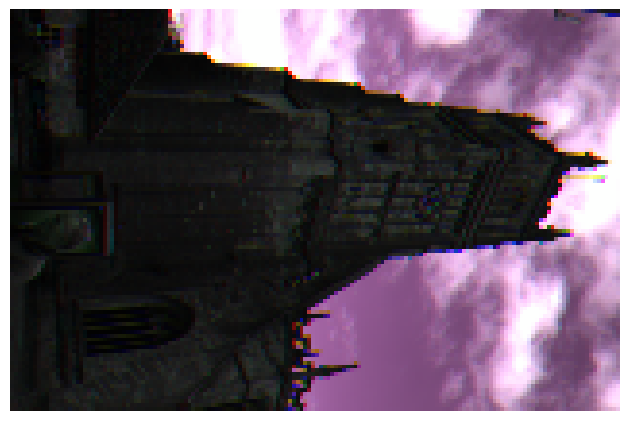

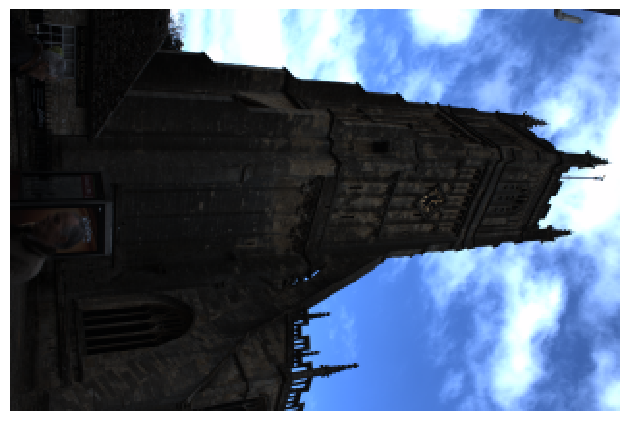

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [12]:
x, y = train_gen.__getitem__(0)
colour.plotting.plot_image(x[0][:,:,1:4])
colour.plotting.plot_image(y[0])

In [13]:
def main_loss(y_true, y_pred):
    return tf.abs(y_true - y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [14]:
from debayering.models import simple_conv

simple_conv_model = simple_conv.get_model()
simple_conv_model.compile(optimizer='adam', loss=main_loss, metrics=[ssim, psnr])
simple_conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 4)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 16)    592       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    2320      
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 12)    1740      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 3)    0         
 ambda)                                                          
                                                                 
Total params: 4,652
Trainable params: 4,652
Non-trainable params: 0
___________________________________________________________

In [15]:
epochs = 100

history = simple_conv_model.fit(
    train_gen, 
    epochs=epochs, 
    validation_data=val_gen, 
    workers=8
)

Epoch 1/100
6/6 [==============================] - 3s 399ms/step - loss: 0.1262 - ssim: 0.2766 - psnr: 14.6735 - val_loss: 0.1083 - val_ssim: 0.3489 - val_psnr: 16.1391
Epoch 2/100
6/6 [==============================] - 2s 299ms/step - loss: 0.0957 - ssim: 0.3298 - psnr: 16.5237 - val_loss: 0.0729 - val_ssim: 0.4350 - val_psnr: 19.5290
Epoch 3/100
6/6 [==============================] - 2s 310ms/step - loss: 0.0662 - ssim: 0.3841 - psnr: 19.8854 - val_loss: 0.0551 - val_ssim: 0.4518 - val_psnr: 21.7180
Epoch 4/100
6/6 [==============================] - 2s 291ms/step - loss: 0.0498 - ssim: 0.5341 - psnr: 22.1189 - val_loss: 0.0386 - val_ssim: 0.6586 - val_psnr: 24.1182
Epoch 5/100
6/6 [==============================] - 2s 310ms/step - loss: 0.0432 - ssim: 0.6084 - psnr: 23.0320 - val_loss: 0.0339 - val_ssim: 0.7003 - val_psnr: 24.8642
Epoch 6/100
6/6 [==============================] - 2s 349ms/step - loss: 0.0408 - ssim: 0.6299 - psnr: 23.5328 - val_loss: 0.0341 - val_ssim: 0.6865 - val_

1/1 [==============================] - 0s 101ms/step


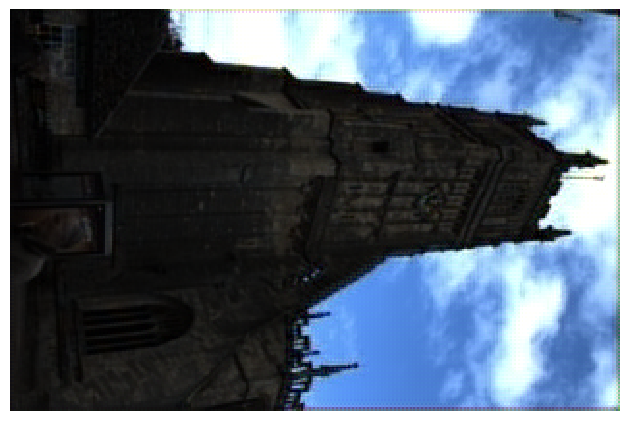

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [19]:
simple_conv_model.evaluate(val_gen)
pred = simple_conv_model.predict(x)
colour.plotting.plot_image(pred[0])

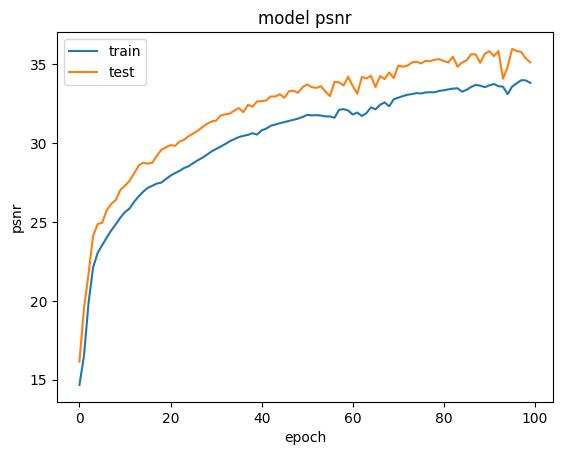

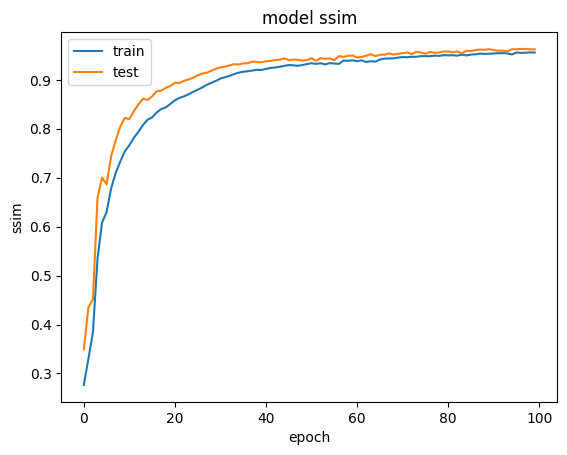

In [20]:
# summarize history for psnr
plt.plot(history.history['psnr'])
plt.plot(history.history['val_psnr'])
plt.title('model psnr')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for ssim
plt.plot(history.history['ssim'])
plt.plot(history.history['val_ssim'])
plt.title('model ssim')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Results

Bileniar
PSNR:  31.4404257724
SSIM:  0.931879263175
Malvar
PSNR:  32.391568235
SSIM:  0.939189145647
Мenon
PSNR:  33.1207515124
SSIM:  0.941916714245
Deep Learning
PSNR:  35.1028
SSIM:  0.9623

## Conclusion

The best results were obtained using the deep learning method. The results of the other methods are not bad, but the deep learning method is better.


## Extra links
- http://www.ok.sc.e.titech.ac.jp/res/DM/RI.pdf